In [1]:
import numpy as np
import importlib
import lab2_proto as proto
import lab2_tools as tools
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

In [27]:
def plot_pcolormesh(res, prop, metric=np.mean):
    
    print(f"Mean diff between example {prop} and our {prop}:", metric(res - example[prop]))
    
    plt.figure()
    plt.subplot(2,1,1)
    plt.pcolormesh(res.T)
    plt.title(prop)
    plt.subplot(2,1,2)
    plt.pcolormesh(example[prop].T)
    plt.tight_layout(h_pad=2.0)
    plt.title(f'{prop} example')
    plt.savefig(f'../../lab1/{prop}.png')
    plt.colorbar()

# Data and model set 
## 3.1 The phonetic models

In [3]:
data = np.load('data/lab2_data.npz', allow_pickle=True)['data']
phoneHMMs = np.load('data/lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
example = np.load("data/lab2_example.npz", allow_pickle=True)['example'].item()

In [4]:
allHMMs = np.load('data/lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
allHMMs.keys()

dict_keys(['f', 'k', 'n', 'r', 's', 't', 'v', 'w', 'z', 'ah', 'ao', 'ay', 'eh', 'ey', 'ih', 'iy', 'ow', 'sp', 'th', 'uw', 'sil'])

In [5]:
# list(example.keys())

In [6]:
# list(sorted(phoneHMMs.keys()))

In [7]:
phoneHMMs['ah'].keys()

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

In [8]:
phoneHMMs['ah']['startprob']

array([1., 0., 0., 0.])

## 3.2 Pronunciation dictionary and utterance models

In [9]:
prondict = {} 
prondict['o'] = ['ow']
prondict['z'] = ['z', 'iy', 'r', 'ow']
prondict['1'] = ['w', 'ah', 'n']
prondict['2'] = ['t', 'uw']
prondict['3'] = ['th', 'r', 'iy']
prondict['4'] = ['f', 'ao', 'r']
prondict['5'] = ['f', 'ay', 'v']
prondict['6'] = ['s', 'ih', 'k', 's']
prondict['7'] = ['s', 'eh', 'v', 'ah', 'n']
prondict['8'] = ['ey', 't']
prondict['9'] = ['n', 'ay', 'n']

In [10]:
isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']
isolated

{'o': ['sil', 'ow', 'sil'],
 'z': ['sil', 'z', 'iy', 'r', 'ow', 'sil'],
 '1': ['sil', 'w', 'ah', 'n', 'sil'],
 '2': ['sil', 't', 'uw', 'sil'],
 '3': ['sil', 'th', 'r', 'iy', 'sil'],
 '4': ['sil', 'f', 'ao', 'r', 'sil'],
 '5': ['sil', 'f', 'ay', 'v', 'sil'],
 '6': ['sil', 's', 'ih', 'k', 's', 'sil'],
 '7': ['sil', 's', 'eh', 'v', 'ah', 'n', 'sil'],
 '8': ['sil', 'ey', 't', 'sil'],
 '9': ['sil', 'n', 'ay', 'n', 'sil']}

# 4 Concatenating HMMs

In [11]:
importlib.reload(proto)
wordHMMs = {}
wordHMMs['o'] = proto.concatHMMs(phoneHMMs, isolated['o'])

# 5 HMM Likelihood and Recognition
## 5.1 Gaussian emission probabilities

In [12]:
importlib.reload(tools)
obsloglik = tools.log_multivariate_normal_density_diag(example["lmfcc"], wordHMMs['o']["means"], wordHMMs['o']["covars"]) 
np.mean((obsloglik - example['obsloglik'])**2)

0.0

In [56]:
example["lmfcc"].shape

(71, 13)

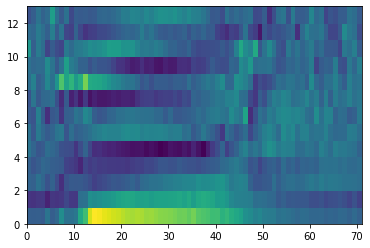

In [13]:
plt.pcolormesh(example["lmfcc"].T)

Mean diff between example obsloglik and our obsloglik: 0.0


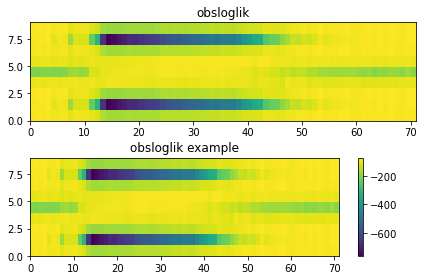

In [14]:
# y axis reprensents tthe different hidden states 
# x axis we have the frames 
# in the start/end [silence] the component that are more probalble got shut down[lower log likelihood] when we start speaking 
plot_pcolormesh(obsloglik, 'obsloglik')

## 5.2 Forward Agorithm

In [15]:
example["obsloglik"].shape

(71, 9)

In [16]:
wordHMMs['o']['startprob'].shape

(10,)

In [17]:
importlib.reload(proto)
log_alpha = proto.forward(example['obsloglik'], np.log(wordHMMs['o']['startprob']), np.log(wordHMMs['o']['transmat']))

D:\Logiciel\anaconda\envs\tf-keras-gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


D:\Logiciel\anaconda\envs\tf-keras-gpu\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
Mean diff between example logalpha and our logalpha: 0.0


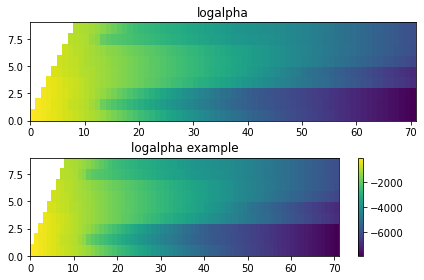

In [18]:
plot_pcolormesh(log_alpha, 'logalpha', np.nanmean)

In [19]:
%%latex 
\begin{align*}
P(x_0, ..., x_n | \theta)  &= \sum_{j=0}^M P(x_0, ..., x_n, z_n= s_j | \theta) \\
    &= \sum_{j=0}^M \alpha_n(j) \\
    &= \sum_{j=0}^M e^{log(\alpha_n(j))}
\end{align*}
\begin{align*}
log(P(x_0, ..., x_n | \theta))  &= log(\sum_{j=0}^M P(x_0, ..., x_n, z_n= s_j | \theta)) \\
    &= log(\sum_{j=0}^M \alpha_n(j)) \\
    &= log(\sum_{j=0}^M e^{log(\alpha_n(j))})
\end{align*}

<IPython.core.display.Latex object>

In [59]:
loglik = tools.logsumexp(log_alpha[-1])
loglik

-5970.427602563561

In [97]:
example['loglik']

-5970.427602563561

In [144]:
# create all the hmm models:
onespeakerHMMs = {}
for digit in prondict.keys():
    onespeakerHMMs[digit] = proto.concatHMMs(phoneHMMs, isolated[digit])

allspeakersHMMs = {}
for digit in prondict.keys():
    allspeakersHMMs[digit] = proto.concatHMMs(allHMMs, isolated[digit])

### compute maximum loglikelihood

In [229]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
importlib.reload(proto)
%time acc = proto.max_loglikelihood(data, onespeakerHMMs, "one", func="forward")
acc

100%|██████████| 44/44 [00:21<00:00,  2.07it/s]Wall time: 21.3 s



77.27

In [230]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
importlib.reload(proto)
%time acc = proto.max_loglikelihood(data, allspeakersHMMs, "all", func="forward")
acc

100%|██████████| 44/44 [00:20<00:00,  2.13it/s]Wall time: 20.7 s



97.73

## 5.3 Viterbi Approximation

In [219]:
importlib.reload(proto)
vloglik, vpath = proto.viterbi(example['obsloglik'], np.log(wordHMMs['o']['startprob']), np.log(wordHMMs['o']['transmat']))

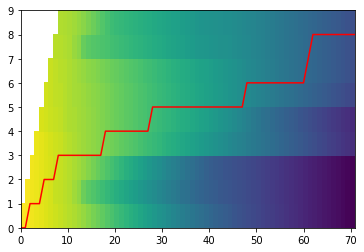

In [223]:
log_alpha = proto.forward(example['obsloglik'], np.log(wordHMMs['o']['startprob']), np.log(wordHMMs['o']['transmat']))
plt.figure()
plt.pcolormesh(log_alpha.T)
plt.plot(range(len(vpath)), vpath, 'r')
plt.colorbar()

In [213]:
example['vloglik']

-5974.211288357338

In [233]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
importlib.reload(proto)
%time acc = proto.max_loglikelihood(data, onespeakerHMMs, "one", "viterbi")
acc

100%|██████████| 44/44 [00:03<00:00, 11.81it/s]Wall time: 3.73 s



77.27

In [234]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
importlib.reload(proto)
%time acc = proto.max_loglikelihood(data, allspeakersHMMs, "all", "viterbi")
acc

100%|██████████| 44/44 [00:03<00:00, 12.46it/s]Wall time: 3.54 s



100.0

## 5.4 Bakward Algorithm

In [42]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
importlib.reload(proto)
log_beta = proto.backward(example['obsloglik'], np.log(wordHMMs['o']['startprob']), np.log(wordHMMs['o']['transmat']))

Mean diff between example logbeta and our logbeta: 0.0


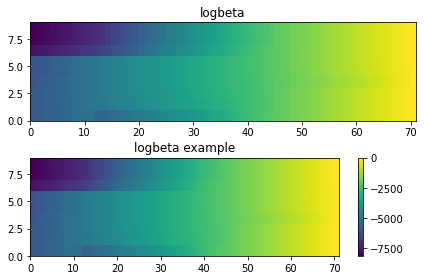

In [43]:
plot_pcolormesh(log_beta, 'logbeta')

# 6 HMM Retraining (emission probability distributions)
## 6.1 State posterior probabilities

In [46]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
importlib.reload(proto)
log_gamma = proto.statePosteriors(example['logalpha'], example['logbeta'])

In [55]:
## check if the probas sum to 1 
N = log_gamma.shape[0]
for n in range(N):
    assert np.isclose([np.sum(np.exp(log_gamma[n]))], [1])

In [78]:
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# importlib.reload(proto)
# log_gamma_gmm = proto.statePosteriorsGMM(example["lmfcc"], wordHMMs['o']['means'], wordHMMs['o']['covars'])
# TODO check gmm gammas

## 6.2 Retraining the emission probability distribution

In [84]:
importlib.reload(proto)
means, covars = proto.updateMeanAndVar(example["lmfcc"], example['loggamma']) 

Convergence after 6 epochs towards -5994.0508169008335


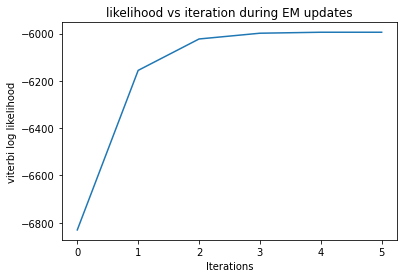

In [152]:
importlib.reload(proto)
hmm = allspeakersHMMs['4']
X = data[10]['lmfcc']
_ = proto.EM(hmm.copy(), X, plot=True)

In [154]:
importlib.reload(proto)
X = data[10]['lmfcc']
lik = {}
for digit in allspeakersHMMs.keys():
    hmm = allspeakersHMMs[digit]
    print(f"EM for digit {digit}")
    lik[digit] = proto.EM(hmm.copy(), X)[-1]

EM for digit o
Convergence after 6 epochs towards -6318.836143374648
EM for digit z
Convergence after 6 epochs towards -5833.270624049372
EM for digit 1
Convergence after 11 epochs towards -5903.338261970013
EM for digit 2
Convergence after 6 epochs towards -6190.713363055121
EM for digit 3
Convergence after 5 epochs towards -6012.101687040111
EM for digit 4
Convergence after 6 epochs towards -5994.0508169008335
EM for digit 5
Convergence after 6 epochs towards -5963.9224257326605
EM for digit 6
Convergence after 6 epochs towards -5884.528943767906
EM for digit 7
Convergence after 6 epochs towards -5682.161964496247
EM for digit 8
Convergence after 5 epochs towards -6185.971631860034
EM for digit 9
Convergence after 6 epochs towards -5953.968391594922


In [158]:
sorted_lik = dict(sorted(lik.items(), key=lambda item: item[1], reverse=True))
sorted_lik

{'7': -5682.161964496247,
 'z': -5833.270624049372,
 '6': -5884.528943767906,
 '1': -5903.338261970013,
 '9': -5953.968391594922,
 '5': -5963.9224257326605,
 '4': -5994.0508169008335,
 '3': -6012.101687040111,
 '8': -6185.971631860034,
 '2': -6190.713363055121,
 'o': -6318.836143374648}